# Спортивные сообщества VK

## _"Определить вид спорта по посту" (Задача классификации)_


Данные: https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification

## Часть 0. Введение

### Обзор

Данный датасет, как мы увидим здесь состоит из 3 колонок и 38740 строк.

**Метаданные**

* **oid** - id сообщества
* **category** - вид спорта (таргет)
* **text** - текст поста

### Контекст:
На основе заданного набора постов определите, какой вид спорта обсуждается в выбранном сообществе.

**Список категорий**

    1.athletics,
    2.autosport,
    3.basketball,
    4.boardgames,
    5.esport,
    6.extreme,
    7.football,
    8.hockey,
    9.martial arts,
    10.motosport,
    11.tennis,
    12.volleyball,
    13.winter_sport
    
### Оценочная метрика:

In [217]:
def score(true, pred, n_samples):
    counter = 0    
    if true == pred:
        counter += 1
    else:
        counter -= 1
    return counter / n_samples

## Часть 1: Импорт, загрузка данных

### Загрузка библиотек

In [218]:
import pandas as pd
import numpy as np

import re
from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

from gensim.models import word2vec

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



### Загрузка данных в датафрейм vk_sport

In [219]:
vk_sport = pd.read_csv('train.csv', encoding_errors = 'ignore')

## Часть 2. Анализ данных (EDA)

In [220]:
vk_sport.head()

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [221]:
vk_sport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38740 entries, 0 to 38739
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       38740 non-null  int64 
 1   category  38740 non-null  object
 2   text      38740 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.1+ KB


В таблице 3 колонки и 38740 строк.  
2 типа данных int64(1 колонка) и object(2 колонки)  
Пропущенных значений нет

In [222]:
vk_sport.describe(include=[object])

,category,text
count,38740,38740
unique,13,35774
top,autosport,За кроссовками в Баскетбольный магазин Ghetto ...
freq,3160,163


В колонке category - 13 уникальных значений.  
В колонке text - есть дублирующие тексты

In [223]:
# количество уникальных сообществ
vk_sport.oid.nunique()

3874

In [224]:
# есть ли сообщества с несколькими категориями?
vk_sport.groupby('oid').category.nunique().to_frame().query('category>1')

,category
oid,


Все сообщества в данном датасете имеют по одной категории

In [225]:
print('Количество классов:', vk_sport.category.nunique())
print('Распределение количества строк по категориям:')
vk_sport.category.value_counts()

Количество классов: 13
Распределение количества строк по категориям:


autosport       3160
extreme         3110
martial_arts    3050
motosport       3030
boardgames      3020
tennis          3000
esport          2990
athletics       2970
hockey          2950
volleyball      2950
football        2860
basketball      2850
winter_sport    2800
Name: category, dtype: int64

<AxesSubplot:>

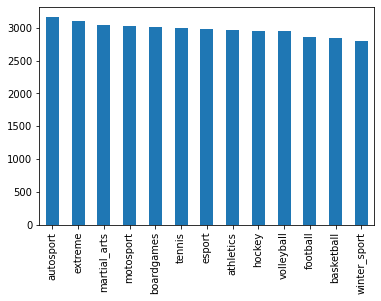

In [226]:
# визуализация распределения таргета "category"
vk_sport['category'].value_counts().plot(x = vk_sport['category'], kind='bar')

In [227]:
vk_sport['oid'].value_counts().unique()

array([10])

Имеем сбалансированный датасет

### Анализ колонки 'text'

In [228]:
# посмотрим на пример текста
vk_sport.at [406,'text']

'Коллеги традиционно объявляем очередной гильдейский настольныйсубботник ГРаНИ 33 По аналогии с индустрией компьютерных игр это предложение по субботам в течение дня выкладывать в комментарии к посту фото своих разработок с кратким описанием. А в ответ на выложенное другими интересоваться советовать предлагать сотрудничество и просто ставить лайки. Рассказывайте над чем сейчас работаете?'

В тексте есть слова содержащие 'tokenoid' - скорее всего являются заменой ссылок.
Есть слова на латинице.
А также цифры и пунктуация.  
Все слова написаны с применением разных регистров.


In [229]:
print(f"В колонке текст имеются дублирующие посты в количестве = {vk_sport['text'].shape[0] - vk_sport['text'].nunique()} строк")

В колонке текст имеются дублирующие посты в количестве = 2966 строк


Также в постах имеется реклама не по тематике спорта, например:

In [230]:
vk_sport.at [21139,'text']

'Плюс – это такой робот помощник который научит вас отдыхать в реальном не киберпанковом мире. Если вы сдали ЕГЭ на 80 и больше баллов получите подписку Яндекс Плюс бесплатно на целый год 33 Подробности здесь'

## Часть 3. Обработка и преобразование данных

### Разделение данных на train и test

In [231]:
train, test = train_test_split(vk_sport, test_size=0.25, random_state=42)

In [232]:
# размеры полученных датасетов
print(f'Размер датасетов train={len(train)}, test={len(test)}')

Размер датасетов train=29055, test=9685


### Приведем тексты постов к общему виду:
 - переводим символы в нижний регистр
 - удалим все слова цифры, пунктуацию и слова содержащие подстроку 'tokenoid'(видимо зашифрованы ссылки)

In [233]:
def clean_text(text):
    text = text.lower()
    # убираем цифры 
    clean_text = re.sub("[0-9]", "", text)
    # убираем ссылки
    clean_text = re.sub(r"([a-z]+)?tokenoid([a-z]+)?", "", text)
    # оставляем только буквенные символы
    clean_text = re.sub("[^а-яa-z]"," ", clean_text)
    # убираем лишние пробелы
    clean_text = re.sub(" +", " ", clean_text)
    return clean_text

In [234]:
# создаем колонку с преобразованным текстом
train['clean_text'] = train['text'].map(clean_text)

In [235]:
print(f"В колонке 'clean_text' количество дублирующих постов = {train['text'].shape[0] - train['clean_text'].nunique()} строк")

В колонке 'clean_text' количество дублирующих постов = 1886 строк


Посчитаем сколько раз каждый пост входит в датасет.
Рассмотрим посты, имеющие дубликаты

In [236]:
train['occurrence'] = train['clean_text'].map(dict(Counter( train['clean_text'].to_list())))

Посмотрим сколько раз дублируются посты.

In [237]:
train['occurrence'].unique()

array([  1,   2, 118,   9,  19,   3,  13,   8,   4,   5,   7,   6,  25,
        24,  10,  37,  11,  26,  14])

Рассмотрим в ручную каждые дубликаты, количество которых больше 3. Создадим список выражений, используемых в тексте реклам.

Например, какие посты были продублированы 13 раз в данном датасете.

In [238]:
train[train['occurrence']==13].head()

,oid,category,text,clean_text,occurrence
30941,211851544,extreme,Друзья кидайте в предложку свои фото и видео с...,друзья кидайте в предложку свои фото и видео с...,13
26439,676443746,boardgames,Приветствуем коллеги 33 А во что вы играли на ...,приветствуем коллеги а во что вы играли на про...,13
1834,933394281,boardgames,Приветствуем коллеги 33 А во что вы играли на ...,приветствуем коллеги а во что вы играли на про...,13
36330,211851544,extreme,Друзья кидайте в предложку свои фото и видео с...,друзья кидайте в предложку свои фото и видео с...,13
38024,702430194,football,Вам не нужно теперь ломать голову что подарить...,вам не нужно теперь ломать голову что подарить...,13


In [239]:
train.at [38024,'text']

'Вам не нужно теперь ломать голову что подарить на праздник. Порадуйте своих близких подарите им бурю эмоций 33 Цены снижены 33 Подробности здесь tokentokenoid'

In [240]:
train[train.clean_text.str.contains('что подарить')].occurrence.value_counts()

13    13
1      9
6      6
2      2
Name: occurrence, dtype: int64

In [241]:
advertisement_words = ['синергия','вакансия','подработка','кэшбэк','постель', 'аналитик данных',\
                       'профессия тестировщик','массажер','свою рекламу','что подарить','яндекс плюс',\
                       'яндекс еда','икеа','бесплатные курсы','бесплатного обслуживания','буст рейтинга',\
                       'ищете подарок']

### Удаление постов с рекламой

Проверяем есть ли выржание из списка и создаем колонку, маркирующую рекламу 1. Сохраняем датасет без рекламы.

In [242]:
def adv_posts(row,words_list):
    adv = 0
    for word in words_list:
        if word in row:
            adv = 1
    return adv

In [243]:
train['adv'] = train.clean_text.apply(lambda row: adv_posts(row,advertisement_words))

In [244]:
train[train.adv==1]

,oid,category,text,clean_text,occurrence,adv
3179,209435461,esport,Желаете видеть свою рекламу здесь пишите в лс ...,желаете видеть свою рекламу здесь пишите в лс ...,4,1
14981,381255868,martial_arts,Да мы предлагаем вам оформить карту Ttokenoid ...,да мы предлагаем вам оформить карту с кэшбэком...,2,1
29862,435839274,volleyball,Альбом Votokenoid Sports Heatokenoid Resort – ...,альбом sports resort всесезонный семейный куро...,1,1
705,449610640,esport,ЗАКАЗ 95309 Буст рейтинга 1530 3780 Доп. опция...,заказ буст рейтинга доп опция выполнить быстре...,6,1
33491,209435461,esport,Желаете видеть свою рекламу здесь пишите в лс ...,желаете видеть свою рекламу здесь пишите в лс ...,4,1
...,...,...,...,...,...,...
25184,671964543,extreme,С картой Wortokenoid of Tanks ваш прогресс в и...,с картой of tanks ваш прогресс в игре пойдет е...,1,1
13773,352942541,martial_arts,Да да это все вам. Бесплатная карта с бесплатн...,да да это все вам бесплатная карта с бесплатно...,5,1
24253,744276650,athletics,Желаете видеть свою рекламу здесь пишите в лс ...,желаете видеть свою рекламу здесь пишите в лс ...,1,1
11653,364867243,esport,ЗАКАЗ 97956 Буст рейтинга 2940 3440 Доп. опция...,заказ буст рейтинга доп опция выполнить быстре...,6,1


In [245]:
train_no_adv = train[train.adv!=1]

### Удаление дубликатов

In [246]:
train_no_adv = train_no_adv.drop_duplicates(subset='clean_text')

In [247]:
print(f'Размер датасетов train={len(train)} и train_no_adv={len(train_no_adv)}')

Размер датасетов train=29055 и train_no_adv=27037


In [248]:
train_no_adv['category'].value_counts().unique()

array([2270, 2210, 2205, 2147, 2084, 2075, 2069, 2048, 2026, 2017, 1963,
       1875])

## Токенизация

In [249]:
import nltk
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

### Удаление стоп-слов

Список стоп-слов для русского языка из библиотеки nltk

In [250]:
from nltk.corpus import stopwords

stop_words_nltk = list(stopwords.words('russian'))

print('Количество стоп-слов библиотеки nltk =',len(stop_words_nltk))

Количество стоп-слов библиотеки nltk = 151


Список стоп слов для русского языка, взят из https://countwordsfree.com/stopwords/russian

In [251]:
# opening the file in read mode
my_file = open("stop_words_russian.txt", "r")
  
# reading the file
stopwords = my_file.read()
  
# replacing end splitting the text 
# when newline ('\n') is seen.
stopwords_list = stopwords.split("\n")
print('Количество стоп-слов из countwordsfree.com =',len(stopwords_list))
my_file.close()

Количество стоп-слов из countwordsfree.com = 421


In [252]:
stop_words_of_sport = ['трансляция','видео','канал']
stopwords_list+=stop_words_of_sport

### Лемматизация

Лемматизация с помощью библиотеки pymorphy2

In [253]:
from pymorphy2 import MorphAnalyzer

lemmatyzer = MorphAnalyzer()

Напишем функцию разделяющее предложение на слова-токены, удаляющее стоп-слова и получающее список токенок лемм

In [254]:
def post_to_wordlist(post_sentence, remove_stopwords=False ):
    # разбиваем предложение на слова по символу пробела
    words = post_sentence.split()
    if remove_stopwords: # убираем стоп-слова
        words = [w for w in words if not w in remove_stopwords and len(w)>1]

    lemma_words = [lemmatyzer.parse(w)[0].normal_form for w in words]

    if remove_stopwords: # убираем стоп-слова
        lemma_words_nostops = [w for w in lemma_words if not w in remove_stopwords]

    return(lemma_words_nostops)

Модель разделения текста на предложения

In [255]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')



Функция разделяющая тексты постов на предложения и применяющая к ним функцию post_to_wordlist

In [256]:
def post_to_sentences(post, tokenizer, remove_stopwords=False):
    # разбиваем пост на предложения
    raw_sentences = tokenizer.tokenize(post.strip())
    sentences = []
    # применяем функцию post_to_wordlist к каждому предложению
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(post_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [257]:
train_no_adv['tokenized_text'] = train_no_adv['clean_text'].apply(lambda row: post_to_wordlist(row, stopwords_list))
train_no_adv['lemmas_string'] = train_no_adv['tokenized_text'].apply(lambda row: ' '.join(row))

## Часть 4: Машинное обучение

In [258]:
def prepose_text(df_text):
    df_text['clean_text'] = df_text['text'].map(clean_text)
    df_text['adv'] = df_text.clean_text.apply(lambda row: adv_posts(row,advertisement_words))
    df_no_adv = df_text[df_text.adv!=1].drop_duplicates(subset='clean_text')
    df_no_adv['tokenized_text'] = df_no_adv['clean_text'].apply(lambda row: post_to_wordlist(row, stopwords_list))
    df_no_adv['lemmas_string'] = df_no_adv['tokenized_text'].apply(lambda row: ' '.join(row))
    return df_no_adv

In [259]:

test_no_adv = prepose_text(test)

In [260]:
X_train = train_no_adv['lemmas_string']
y_train = train_no_adv['category']

X_test = test_no_adv['lemmas_string']
y_test = test_no_adv['category']


### Создаем таблицу метрик
Таблица с результатами полученных метрик для разных моделей

In [96]:
df_models_accuracy = pd.DataFrame(columns=['Название модели', 'Векторизатор текста', 'Accuracy'])

**Naive Bayes model - baseline -**

In [97]:
mnb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb_clf', MultinomialNB())])

mnb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mnb_clf', MultinomialNB())])

In [98]:
predicted_mnb = mnb_ppl_clf.predict(X_test)

print(metrics.classification_report(predicted_mnb, y_test))

              precision    recall  f1-score   support

   athletics       0.92      0.81      0.86       754
   autosport       0.90      0.79      0.84       887
  basketball       0.81      0.97      0.89       514
  boardgames       0.96      0.84      0.89       798
      esport       0.69      0.88      0.77       547
     extreme       0.75      0.68      0.71       816
    football       0.72      0.89      0.80       569
      hockey       0.89      0.86      0.88       777
martial_arts       0.75      0.84      0.79       616
   motosport       0.84      0.89      0.87       694
      tennis       0.97      0.92      0.94       784
  volleyball       0.87      0.82      0.85       793
winter_sport       0.88      0.85      0.87       729

    accuracy                           0.84      9278
   macro avg       0.84      0.85      0.84      9278
weighted avg       0.85      0.84      0.84      9278



In [99]:
# добавляем первую полученную метрику в таблицу
df_models_accuracy.loc[len(df_models_accuracy.index)] = ['Naive Bayes', 'TF-IDF', metrics.accuracy_score(predicted_mnb, y_test)]

In [100]:
df_models_accuracy

,Название модели,Векторизатор текста,Accuracy
0,Naive Bayes,TF-IDF,0.843285


**RandomForest model**

In [101]:
rf_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf_clf', RandomForestClassifier())])

rf_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('rf_clf', RandomForestClassifier())])

In [103]:
predicted_rf = rf_ppl_clf.predict(X_test)

print(metrics.classification_report(predicted_rf, y_test))

              precision    recall  f1-score   support

   athletics       0.92      0.88      0.90       692
   autosport       0.84      0.85      0.84       765
  basketball       0.84      0.89      0.86       581
  boardgames       0.94      0.93      0.93       707
      esport       0.76      0.65      0.70       807
     extreme       0.77      0.66      0.71       874
    football       0.74      0.75      0.74       697
      hockey       0.79      0.86      0.82       691
martial_arts       0.74      0.79      0.77       642
   motosport       0.84      0.88      0.86       706
      tennis       0.95      0.93      0.94       762
  volleyball       0.83      0.94      0.88       659
winter_sport       0.84      0.85      0.84       695

    accuracy                           0.83      9278
   macro avg       0.83      0.84      0.83      9278
weighted avg       0.83      0.83      0.83      9278



In [104]:
# добавляем первую полученную метрику в таблицу
df_models_accuracy.loc[len(df_models_accuracy.index)] = ['Random Forest', 'TF-IDF', metrics.accuracy_score(predicted_rf, y_test)]

**Стохастический градиентный спуск - SGD**

In [105]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords_list)),
    ('sgd_clf', SGDClassifier(random_state=42))])

sgd_ppl_clf.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['а', 'е', 'и', 'ж', 'м', 'о', 'на',
                                             'не', 'ни', 'об', 'но', 'он',
                                             'мне', 'мои', 'мож', 'она', 'они',
                                             'оно', 'мной', 'много',
                                             'многочисленное', 'многочисленная',
                                             'многочисленные', 'многочисленный',
                                             'мною', 'мой', 'мог', 'могут',
                                             'можно', 'может', ...])),
                ('sgd_clf', SGDClassifier(random_state=42))])

In [106]:
predicted_sgd = sgd_ppl_clf.predict(X_test)

print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

   athletics       0.93      0.92      0.92       665
   autosport       0.88      0.89      0.89       776
  basketball       0.91      0.94      0.92       596
  boardgames       0.97      0.84      0.90       810
      esport       0.76      0.85      0.80       623
     extreme       0.75      0.81      0.78       694
    football       0.83      0.83      0.83       710
      hockey       0.86      0.91      0.88       714
martial_arts       0.83      0.84      0.84       674
   motosport       0.91      0.86      0.88       776
      tennis       0.97      0.95      0.96       770
  volleyball       0.91      0.91      0.91       748
winter_sport       0.90      0.88      0.89       722

    accuracy                           0.88      9278
   macro avg       0.88      0.88      0.88      9278
weighted avg       0.88      0.88      0.88      9278



In [107]:
# добавляем первую полученную метрику в таблицу
df_models_accuracy.loc[len(df_models_accuracy.index)] = ['SGDClassifier', 'TF-IDF', metrics.accuracy_score(predicted_sgd, y_test)]

**KNeighbors Model**

In [108]:
knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

knb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

In [109]:
predicted_knb = knb_ppl_clf.predict(X_test)

print(metrics.classification_report(predicted_knb, y_test))

              precision    recall  f1-score   support

   athletics       0.92      0.68      0.78       887
   autosport       0.81      0.82      0.81       772
  basketball       0.85      0.80      0.82       656
  boardgames       0.94      0.86      0.90       766
      esport       0.72      0.76      0.74       661
     extreme       0.66      0.77      0.71       644
    football       0.71      0.81      0.76       616
      hockey       0.80      0.82      0.81       737
martial_arts       0.74      0.82      0.77       619
   motosport       0.84      0.86      0.85       720
      tennis       0.94      0.93      0.94       763
  volleyball       0.84      0.78      0.81       805
winter_sport       0.81      0.90      0.85       632

    accuracy                           0.81      9278
   macro avg       0.81      0.82      0.81      9278
weighted avg       0.82      0.81      0.81      9278



In [110]:
# добавляем первую полученную метрику в таблицу
df_models_accuracy.loc[len(df_models_accuracy.index)] = ['KNeighbors', 'TF-IDF', metrics.accuracy_score(predicted_knb, y_test)]

In [111]:
df_models_accuracy

,Название модели,Векторизатор текста,Accuracy
0,Naive Bayes,TF-IDF,0.843285
1,Random Forest,TF-IDF,0.829705
2,SGDClassifier,TF-IDF,0.877775
3,KNeighbors,TF-IDF,0.813214


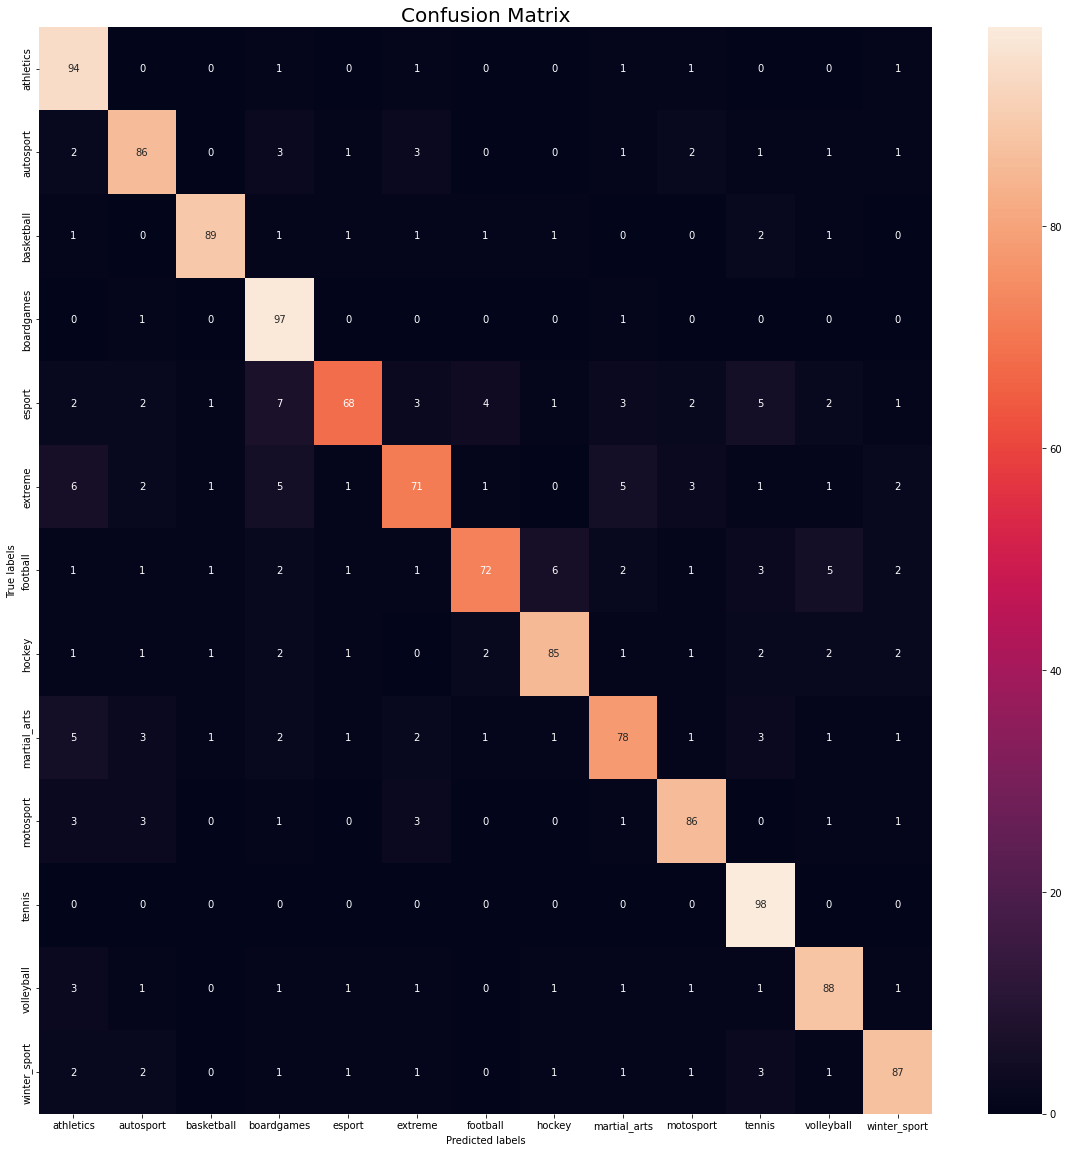

In [162]:
cmm = metrics.confusion_matrix(y_test, predicted_sgd, normalize='true')

lables = y_train.drop_duplicates()
T13_lables = sorted(lables)

plt.figure(figsize=(20, 20))

ax= plt.subplot()

sns.heatmap(np.rint(cmm*100), annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix', fontdict={'fontsize':20}, pad=5); 
ax.xaxis.set_ticklabels(T13_lables); ax.yaxis.set_ticklabels(T13_lables);

In [155]:
from sklearn.model_selection import GridSearchCV
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'sgd_clf__alpha': (1e-2, 1e-3, 1e-4)
             }

search = GridSearchCV(sgd_ppl_clf, parameters)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.858):
{'sgd_clf__alpha': 0.0001, 'tfidf__ngram_range': (1, 1), 'tfidf__use_idf': True}


In [154]:
1e-3

0.001

In [165]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/d6/af/cb5ea6d1a9c83e715e29b45a598ebf542729cd216b43f5deefc27657bd38/tensorflow-2.13.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 527.2 kB/s eta 0:00:001m517.2 kB/s eta 0:00:01
  Obtaining dependency information for flatbuffers>=23.1.21 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.3 MB/s eta 0:00:001.5 MB/s eta 0:00:01
  Obtaining dependency information for grpcio<2.0,>=1.24.3 from https://files.pythonhosted.org/packages/69/67/46ce6471c94af40118d728caa7e840fd55c70878dcfdad9837003e5863b6/grpcio-1.57.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for h5py>=2.9.0 from https://files.python

  Obtaining dependency information for cachetools<6.0,>=2.0.0 from https://files.pythonhosted.org/packages/a9/c9/c8a7710f2cedcb1db9224fdd4d8307c9e48cbddc46c18b515fefc0f1abbe/cachetools-5.3.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 875.5 kB/s eta 0:00:00 kB/s eta 0:00:01:01
  Obtaining dependency information for importlib-metadata>=4.4 from https://files.pythonhosted.org/packages/cc/37/db7ba97e676af155f5fcb1a35466f446eadc9104e25b83366e8088c9c926/importlib_metadata-6.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for MarkupSafe>=2.1.1 from https://files.pythonhosted.org/packages/de/63/cb7e71984e9159ec5f45b5e81e896c8bdd0e45fe3fc6ce02ab497f0d790e/MarkupSafe-2.1.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for zipp>=0.5 from https://files.pythonhosted.org/packages/8c/08/d3006317aefe25ea79d3b76c9650afabaf6d63d1c8443b236e7405447503/zipp-3.16.2-py3-none-any.whl.metadata
     

In [293]:
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# модуль для разбиения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split 

# Основные слои
from tensorflow.keras.layers import Input, Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
from IPython.display import display

%matplotlib inline

In [338]:
X_train = train_no_adv['lemmas_string']
y_train = train_no_adv['category']

X_test = test_no_adv['lemmas_string']
y_test = test_no_adv['category']

In [339]:
# Посчитаем максимальную длину поста в словах
train_no_adv['tokenized_text']

max_words = 0
for post in train_no_adv['tokenized_text']:
    words = len(post)
    if words > max_words:
        max_words = words
print('Максимальная длина поста: {} слов'.format(max_words))


Максимальная длина поста: 353 слов


In [340]:
from keras.preprocessing.text import Tokenizer

# создаем единый словарь (слово -> число) для преобразования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.tolist())

# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
trainSequences = tokenizer.texts_to_sequences(X_train.tolist())
testSequences = tokenizer.texts_to_sequences(X_test.tolist())

In [341]:
total_words = len(tokenizer.word_index)
print('В словаре {} слов'.format(total_words))

В словаре 58777 слов


In [342]:
# количество наиболее часто используемых слов
num_words = 10000

print(u'Преобразуем описания заявок в векторы чисел...')
tokenizer = Tokenizer(num_words=num_words)
X_train = tokenizer.sequences_to_matrix(trainSequences, mode='binary')
X_test = tokenizer.sequences_to_matrix(testSequences, mode='binary')
print('Размерность X_train:', X_train.shape)
print('Размерность X_test:', X_test.shape)

Преобразуем описания заявок в векторы чисел...
Размерность X_train: (27037, 10000)
Размерность X_test: (9278, 10000)


In [343]:
def category_code(y_train):
    y_train = y_train.to_frame()
    y_train["category"] = y_train["category"].astype('category')
    y_train["category_code"] = y_train["category"].cat.codes
    return y_train['category_code']

y_train = category_code(y_train)
y_test = category_code(y_test)


In [344]:
print(u'Преобразуем категории в матрицу двоичных чисел '
      u'(для использования categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, 13)
y_test = keras.utils.to_categorical(y_test, 13)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)
y_train shape: (27037, 13)
y_test shape: (9278, 13)


In [345]:
# количество эпох\итераций для обучения
epochs = 10

print(u'Собираем модель...')
model = Sequential()
model.add(Dense(512, input_shape=(num_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(13))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Собираем модель...
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               5120512   
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 13)                6669      
                                                                 
 activation_5 (Activation)   (None, 13)                0         
                                                                 
Total params: 5127181 (19.56 MB)
Trainable params: 5127181 (19.56 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________________________

In [346]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=epochs,
                    verbose=1,validation_data = (X_test, y_test))

Epoch 1/10


2023-08-12 08:43:12.025456: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1081480000 exceeds 10% of free system memory.


845/845 [==============================] - ETA: 0s - loss: 0.8211 - accuracy: 0.7905

2023-08-12 08:44:06.947658: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 371120000 exceeds 10% of free system memory.


845/845 [==============================] - 57s 67ms/step - loss: 0.8211 - accuracy: 0.7905 - val_loss: 0.5294 - val_accuracy: 0.8534
Epoch 2/10
845/845 [==============================] - 56s 66ms/step - loss: 0.2612 - accuracy: 0.9281 - val_loss: 0.5473 - val_accuracy: 0.8558
Epoch 3/10
845/845 [==============================] - 56s 66ms/step - loss: 0.1172 - accuracy: 0.9721 - val_loss: 0.6320 - val_accuracy: 0.8527
Epoch 4/10
845/845 [==============================] - 57s 67ms/step - loss: 0.0609 - accuracy: 0.9882 - val_loss: 0.7207 - val_accuracy: 0.8465
Epoch 5/10
845/845 [==============================] - 57s 68ms/step - loss: 0.0406 - accuracy: 0.9939 - val_loss: 0.8109 - val_accuracy: 0.8435
Epoch 6/10
845/845 [==============================] - 59s 70ms/step - loss: 0.0316 - accuracy: 0.9957 - val_loss: 0.8784 - val_accuracy: 0.8364
Epoch 7/10
845/845 [==============================] - 67s 79ms/step - loss: 0.0233 - accuracy: 0.9970 - val_loss: 0.9422 - val_accuracy: 0.8370
Epo

In [347]:
score = model.evaluate(X_test, y_test,
                       batch_size=32, verbose=1)
print()
print(u'Оценка теста: {}'.format(score[0]))
print(u'Оценка точности модели: {}'.format(score[1]))

290/290 [==============================] - 4s 14ms/step - loss: 1.0927 - accuracy: 0.8374

Оценка теста: 1.0927056074142456
Оценка точности модели: 0.8373571634292603


**LSTM**

In [328]:
maxSequenceLength = max_words

In [329]:
X_train = utils.pad_sequences(X_train, maxlen=maxSequenceLength)
X_test = utils.pad_sequences(X_test, maxlen=maxSequenceLength)

print('Размерность X_train:', X_train.shape)
print('Размерность X_test:', X_test.shape)

Размерность X_train: (27037, 353)
Размерность X_test: (9278, 353)


In [330]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

Собираем модель...
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 353)         2074934   
                                                                 
 lstm_4 (LSTM)               (None, 32)                49408     
                                                                 
 dense_4 (Dense)             (None, 13)                429       
                                                                 
Total params: 2124771 (8.11 MB)
Trainable params: 2124771 (8.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [331]:
batch_size = 32
epochs = 3

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

Тренируем модель...
Epoch 1/3
845/845 [==============================] - 559s 658ms/step - loss: 0.2803 - accuracy: 0.0809 - val_loss: 0.2712 - val_accuracy: 0.0740
Epoch 2/3
845/845 [==============================] - 615s 728ms/step - loss: 0.2714 - accuracy: 0.0842 - val_loss: 0.2713 - val_accuracy: 0.0815
Epoch 3/3
845/845 [==============================] - 567s 671ms/step - loss: 0.2715 - accuracy: 0.0809 - val_loss: 0.2713 - val_accuracy: 0.0839


In [325]:
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print()
print(u'Оценка теста: {}'.format(score[0]))
print(u'Оценка точности модели: {}'.format(score[1]))

290/290 [==============================] - 2s 6ms/step - loss: 0.2713 - accuracy: 0.0812

Оценка теста: 0.27132147550582886
Оценка точности модели: 0.08115973323583603


In [335]:
cur_time = time.time() # засекаем время

nDense = 13
nDropout = 0.4
epochs = 10
nlr = 0.0001
nEmbedding = 50

input_layer = Input(shape=(maxSequenceLength, ))
GRU_1 = Embedding(total_words, nEmbedding, input_length = maxSequenceLength)(input_layer)
GRU_2 = SpatialDropout1D(nDropout)(GRU_1)
#SimpleRNN_3 = SimpleRNN(xLen//10, dropout=nDropout, recurrent_dropout=nDropout, activation="relu")(SimpleRNN_2) # сильно замедляет
GRU_3 = GRU(maxSequenceLength, return_sequences=True)(GRU_2) # правильно поставить от xLen, return_sequences=True - сохранять выходные значения на каждой итерации работы слоя 
GRU_4 = Flatten()(GRU_3)
GRU_5 = Dense(nDense, activation='softmax')(GRU_4)

modelGRU = Model(inputs=input_layer, outputs=GRU_5)
modelGRU.compile(optimizer=Adam(nlr), loss='categorical_crossentropy', metrics=['accuracy'])
    
# остановки обучения по условию 
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 2, verbose = 1,  restore_best_weights = True)

#Обучаем на xTrain
history = modelGRU.fit(X_train, y_train, epochs=epochs, verbose = 1,
                             callbacks = early_stopping,
                             validation_data = (X_test, y_test))

Epoch 1/10
513/845 [=================>............] - ETA: 10:10 - loss: 2.5740 - accuracy: 0.0762


KeyboardInterrupt

